# WRF-Python Tutorial 2017
<p></p>


## Bill Ladwig
## NCAR/CISL/VAST

# Topics

1. Introduction to jupyter notebooks, numpy, xarray
2. Overview of WRF-ARW Output Data
3. wrf-python
4. Plotting
5. Advanced

# 1.0 Introduction to jupyter, numpy, xarray

## What is jupyter notebook?

- The Jupyter Notebook is an open-source web application that allows you to create and share documents that contain live code, equations, visualizations and explanatory text. 

- The Jupyter Notebook actually consists of a document and an application

- The Jupyter Notebook application is a web browser application that allows editing and executing of jupyter notebook documents.


## What is jupyter notebook?

- Jupyter Notebook documents (usually ending with a .ipynb extension), are really just JSON-formatted text files that contain the code and rich text elements that will be rendered by the jupyter notebook application.  

- Jupyter notebook documents are NOT Python scripts, so do not try to run them via the 'python' command.  They need to be converted first.

- For this tutorial, when we refer to jupyter notebook, we're referring to both the application and document.

## Starting jupyter notebook

If you followed the installation instructions on the web, you should have created a "tutorial_2017" conda environment.  

To activate it, first open a terminal and type in:

```
source activate tutorial_2017 [Linux/Mac]

activate tutorial_2017 [Windows]
```

Raise your hand if you need help.

## Starting jupyter notebook

Now go to the directory where you stored the tutorial files (e.g. ~/wrf_python_tutorial) and execute the command "jupyter notebook"

```

cd ~/wrf_python_tutorial

[cd %HOMEPATH%\wrf_python_tutorial]

jupyter notebook

```

If for some reason the browser does not launch automatically (Mac Sierra Users), open a web browser and go to:

```
http://localhost:8888
```

Your web browser should look similar to this:
 
![alt](images/jupyter_home.png)


Now click on the "wrf_python_student.ipynb" link (just click the text).  

This should open a new browser tab that looks like:

![alt](images/jupyter_workbook.png)


# Cells

- A jupyter notebook is a collection of cells, similar to Mathematica.

- Cells can be either executable code or text (markdown).

- Cells can also be specified as slides, which is how this slide show was made (along with the Rise plugin)

# Cells

- Entering and executing code in cells is the same as having typed it in to the Python 
  shell program.
- The order of execution of the cells can have impacts on variables that are used across
  the cells, so be careful when re-running cells.
- Aside from the first cell you run, the cells used in this tutorial should be more like
  independent scripts.
  

## Executing Cells

1. Click on the desired cell.
2. Press **CTRL + RETURN** to execute the cell or press **SHIFT + RETURN** to execute the cell and advance to the next cell.
3. Alternatively, you can use the Cell dropdown menu

## Restarting the Notebook

If your notebook crashes for some reason:

1. Use the Kernel dropdown menu at the top.
2. Execute Kernel -> Restart & Clear Output.


## Shutting down the notebook

1. On your web browser, select the Home tab.
2. Click the check box next to wrf_python_student.ipynb.
3. Click the Shutdown button that will become available after step 2.
4. Now go to the terminal window where you typed in "jupyter notebook".
5. With the terminal window active, press **CTRL + C**.

# 1.1 Verifying your Jupyter Environment

To set up the tutorial to work with your files, modify the WRF_DIRECTORY and WRF_FILES variables to point to your WRF files.

**IMPORTANT**:  If for some reason your workbook crashes, you need to run this cell again before running the later examples.

In [1]:
from __future__ import print_function

# This jupyter notebook command inserts matplotlib graphics in 
# to the workbook
%matplotlib inline

# Modify these to point to your own files
WRF_DIRECTORY = "~/wrf_tutorial_data"
WRF_FILES = ["wrfout_d01_2005-08-28_00_00_00",
             "wrfout_d01_2005-08-28_12_00_00",
             "wrfout_d01_2005-08-29_00_00_00"]


# Do not modify the code below this line
#------------------------------------------------------
# Make sure the environment is good
import numpy
import cartopy
import matplotlib
from netCDF4 import Dataset
from xarray import DataArray
from wrf import (getvar, interplevel, vertcross, 
                 vinterp, ALL_TIMES)
import os

_WRF_FILES = [os.path.abspath(os.path.expanduser(
    os.path.join(WRF_DIRECTORY, f))) for f in WRF_FILES]

# Check that the WRF files exist
for f in _WRF_FILES:
    if not os.path.exists(f):
        raise ValueError("{} does not exist. "
            "Check for typos or incorrect directory.".format(full_path))

# Create functions so that the WRF files only need
# to be specified using the WRF_FILES global above
def single_wrf_file():
    global _WRF_FILES
    return _WRF_FILES[0]

def multiple_wrf_files():
    global _WRF_FILES
    return _WRF_FILES

print ("All tests passed!")
    


All tests passed!


# Numpy

- numpy is a python package for doing array based operations, similar to matlab and NCL
- Numpy arrays can be created for the common types in C (named "dtype" in numpy)
  - int8, int16, int32, int64 (and unsigned versions)
  - float16, float32 [default], float64
  - bool
  - complex64, complex128
- Arrays can be C-ordered (fastest on right) or Fortran-ordered (fastest on left)

# Numpy Basics

## Array Creation

In this example, we're going to create an array of all zeros with 3x3x3 shape.

Here is how to create an array of floats and then integers.

``` python

import numpy

array_float32 = numpy.zeros((3,3,3), "float32")

array_int32 = numpy.zeros((3,3,3), "int32")

```


## Accessing Elements

- To access elements in numpy, you use the bracket "[ ]" syntax.  

- Supply each desired index separated by commas (this is really a tuple).

- You can use also negative indexes to pick indexes from the end.


``` python

import numpy

my_array = numpy.zeros((3,3,3), "float32")

# Getting elements
first_element = my_array[0,0,0]

last_element = my_array[-1,-1,-1]

mid_element = my_array[1,1,1]

# Setting an element
my_array[1,1,1] = 10.0

```

## Slices

- Slices are a way to extract array subsets from and array.
- The syntax for a slice is the ':' character.
- Specifying the ':' for a dimension will return all values along that dimension.
- Specifying 'start : end' will take a subset of that dimension. Also, either *start* or *end* can be left blank.

``` python
import numpy

my_array = numpy.zeros((3,3,3), "float32")

first_row = my_array[0,0,:]

first_column = my_array[0,:,0]

first_z = my_array[:,0,0]

subset = my_array[:, :, 1:3]

```

Also, slices are implicitly applied from left to right for unspecified dimensions.

``` python
import numpy

my_array = numpy.zeros((3,3,3), "float32")

first_plane = my_array[0,:,:]

# This is the same as first_plane
first_plane2 = my_array[0]

# A short way to get everything
# Same as my_array[:,:,:]
all_elements = my_array[:]

```

# Masked Arrays

- numpy uses a numpy array subclass called a MaskedArray
- MaskedArrays are just numpy arrays with some elements set to a fill_value
- Numerous ways to convert a regular numpy array to a MaskedArray:
  - masked_equal
  - masked_greater
  - masked_where


## Creating a MaskedArray

``` python

import numpy
import numpy.ma

my_array = numpy.zeros((3,3,3), "float32")

# Now all the array elements are masked values
my_masked = numpy.ma.masked_equal(my_array, 0)

```

# Your Turn!

## Example 1.2: Numpy Basics

In [2]:
import numpy
import numpy.ma

my_array = numpy.zeros((3,3,3), "float32")

print ("my_array")
print (my_array)
print ("\n")

# Setting an element
my_array[1,1,1] = 10.0

# Getting an element
mid = my_array[1,1,1]

print ("Mid element set")
print (my_array)
print ("\n")

# Getting a slice
my_slice = my_array[1,:,:]

print ("my_slice")
print (my_slice)
print ("\n")

# Masking the zeros
my_masked = numpy.ma.masked_equal(my_array, 0)

print ("my_masked")
print (my_masked)
print ("\n")





my_array
[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]


Mid element set
[[[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.  10.   0.]
  [  0.   0.   0.]]

 [[  0.   0.   0.]
  [  0.   0.   0.]
  [  0.   0.   0.]]]


my_slice
[[  0.   0.   0.]
 [  0.  10.   0.]
 [  0.   0.   0.]]


my_masked
[[[-- -- --]
  [-- -- --]
  [-- -- --]]

 [[-- -- --]
  [-- 10.0 --]
  [-- -- --]]

 [[-- -- --]
  [-- -- --]
  [-- -- --]]]




# xarray

- xarray expands upon numpy by adding dimension names, coordinate variables, and metadata.  
- xarray array (DataArray) objects wrap around a numpy array (NOT a numpy array subclasses).
  - xarray **HAS A** numpy array (it is not an "IS A" relationship)
  - Often have to extract the numpy array from the xarray array before passing it to extension modules
  - Some numpy methods not available in xarray
- Most numpy attributes, operations, and methods are available to xarray arrays.

## Creating an xarray Array from a numpy Array 

``` python
import numpy
import xarray

my_array = numpy.zeros((3,3,3), "float32")

# Making up dimension names and 
# coordinates.
my_name = "my_xarray"

my_dims = ["bottom_top", "south_north",
           "west_east"]

my_coords = {"bottom_top" : 
                   [100., 200., 300.],
          "south_north": 
                   [40., 50., 60.],
          "west_east" : 
                   [-120., -110., -100.]
         }

my_attrs = {"info" : "This is my xarray"}

my_xarray = xarray.DataArray(my_array,
                        name=my_name,
                        dims=my_dims, 
                        coords=my_coords, 
                        attrs=my_attrs)

```

## Your Turn!

### Example 1.3: Creating an xarray DataArray

In [3]:
import numpy
import xarray

my_array = numpy.zeros((3,3,3), "float32")

# Making up dimension names and 
# coordinates.
my_name = "my_xarray"

my_dims = ["bottom_top", "south_north", "west_east"]

my_coords = {"bottom_top" : [100., 200., 300.],
          "south_north": [40., 50., 60.],
          "west_east" : [-120., -110., -100.]
         }

my_attrs = {"info" : "This is my xarray"}

my_xarray = xarray.DataArray(my_array,
                           name=my_name,
                           dims=my_dims, 
                           coords=my_coords, 
                           attrs=my_attrs)

print (my_xarray)


<xarray.DataArray 'my_xarray' (bottom_top: 3, south_north: 3, west_east: 3)>
array([[[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]],

       [[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]], dtype=float32)
Coordinates:
  * south_north  (south_north) float64 40.0 50.0 60.0
  * west_east    (west_east) float64 -120.0 -110.0 -100.0
  * bottom_top   (bottom_top) float64 100.0 200.0 300.0
Attributes:
    info:     This is my xarray


## xarray and Missing Data Values

- xarray always uses NaN for missing data values.
  - Can cause problems with compiled numerical routines.
  - Can cause problems for algorithms expecting MaskedArrays.
- wrf-python includes the fill value information in the attr section of the metadata (_FillValue).
- The *to_np* routine can be used to convert xarray arrays to numpy/masked arrays.
  

## Your Turn!

## Example 1.4: xarray and Missing Values

In [4]:
import numpy
import numpy.ma
import xarray

from wrf import to_np

# Create a MaskedArray with 10.0 in the center
my_array = numpy.zeros((3,3,3), "float32")

my_array[1,1,1] = 10.0

my_masked = numpy.ma.masked_equal(my_array, 0)

# Making up dimension names and 
# coordinates.
my_name = "my_masked_xarray"

my_dims = ["bottom_top", "south_north", "west_east"]

my_coords = {"bottom_top" : [100., 200., 300.],
          "south_north": [40., 50., 60.],
          "west_east" : [-120., -110., -100.]
         }

my_attrs = {"info" : "This is my masked xarray",
           "_FillValue" : -999.0}

# Create the xarray DataArray
my_xarray = xarray.DataArray(my_masked,
                           name=my_name,
                           dims=my_dims, 
                           coords=my_coords, 
                           attrs=my_attrs)

print ("xarray Array with Missing Values")
print (my_xarray)
print ("\n")

# Covert back to a MaskedArray
converted = to_np(my_xarray)

print ("Converted to a MaskedArray with to_np")
print (converted)

xarray Array with Missing Values
<xarray.DataArray 'my_masked_xarray' (bottom_top: 3, south_north: 3, west_east: 3)>
array([[[ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan]],

       [[ nan,  nan,  nan],
        [ nan,  10.,  nan],
        [ nan,  nan,  nan]],

       [[ nan,  nan,  nan],
        [ nan,  nan,  nan],
        [ nan,  nan,  nan]]], dtype=float32)
Coordinates:
  * south_north  (south_north) float64 40.0 50.0 60.0
  * west_east    (west_east) float64 -120.0 -110.0 -100.0
  * bottom_top   (bottom_top) float64 100.0 200.0 300.0
Attributes:
    info:        This is my masked xarray
    _FillValue:  -999.0


Converted to a MaskedArray with to_np
[[[-- -- --]
  [-- -- --]
  [-- -- --]]

 [[-- -- --]
  [-- 10.0 --]
  [-- -- --]]

 [[-- -- --]
  [-- -- --]
  [-- -- --]]]


# 2.0 Overview of WRF Output Data

The first rule of data processing:

**"ALWAYS LOOK AT YOUR DATA"**

\- D. Shea

## Why Look At WRF Data? Isn't It All the Same?

- WRF can be configured in various ways and can have variables turned on and off.  
- If you run in to problems, it could be due to a variable missing.  
- If your plot doesn't look right, there could be a map projection issue.





## Data Viewing Tools
There are numerous tools available to examine NetCDF data, from both outside and inside of Python.

- **ncdump** (used for this example)
- ncl_filedump
- netcdf4-python 
- xarray

## ncdump

ncdump is a program included with the NetCDF libraries that can be used to examine NetCDF data.

By supplying the '-h' option, only the data descriptions are returned.  Otherwise, you'll get all of the data values, which can span miles.

To run:

```
$ ncdump -h wrfout_d01_2005-08-28_00:00:00
```

## ncdump Output
<p></p>
<div id="nc_dims" style="font-size:75%;"/>
``` 
netcdf wrfout_d01_2005-08-28_00\:00\:00 {
dimensions:
    Time = UNLIMITED ; // (4 currently)
    
    DateStrLen = 19 ;
    
    west_east = 90 ;
    
    south_north = 73 ;
    
    bottom_top = 29 ;
    
    bottom_top_stag = 30 ;
    
    soil_layers_stag = 4 ;
    
    west_east_stag = 91 ;
    
    south_north_stag = 74 ;
    
```
</div>



## ncdump Output
<p></p>
<div id="nc_vars" style="font-size:75%;">
```
variables:
    char Times(Time, DateStrLen) ;
    float XLAT(Time, south_north, west_east) ;
        XLAT:FieldType = 104 ;
        XLAT:MemoryOrder = "XY " ;
        XLAT:description = "LATITUDE, SOUTH IS NEGATIVE" ;
        XLAT:units = "degree_north" ;
        XLAT:stagger = "" ;
        XLAT:coordinates = "XLONG XLAT" ;
    float XLONG(Time, south_north, west_east) ;
        XLONG:FieldType = 104 ;
        XLONG:MemoryOrder = "XY " ;
        XLONG:description = "LONGITUDE, WEST IS NEGATIVE" ;
        XLONG:units = "degree_east" ;
        XLONG:stagger = "" ;
        XLONG:coordinates = "XLONG XLAT" ;
        .
        .
        .
    float SST_INPUT(Time, south_north, west_east) ;
        SST_INPUT:FieldType = 104 ;
        SST_INPUT:MemoryOrder = "XY " ;
        SST_INPUT:description = "SEA SURFACE TEMPERATURE 
            FROM WRFLOWINPUT FILE" ;
        SST_INPUT:units = "K" ;
        SST_INPUT:stagger = "" ;
        SST_INPUT:coordinates = "XLONG XLAT XTIME" ;
```
</div>

## ncdump Output
<p></p>
<div id="nc_attrs" style="font-size:75%;">
```
// global attributes:
        :TITLE = " OUTPUT FROM WRF V3.7 MODEL" ;
        :START_DATE = "2005-08-28_00:00:00" ;
        :SIMULATION_START_DATE = "2005-08-28_00:00:00" ;
        :WEST-EAST_GRID_DIMENSION = 91 ;
        :SOUTH-NORTH_GRID_DIMENSION = 74 ;
        :BOTTOM-TOP_GRID_DIMENSION = 30 ;
        :DX = 30000.f ;
        :DY = 30000.f ;
        .
        .
        .
        :CEN_LAT = 28.00002f ;
        :CEN_LON = -89.f ;
        :TRUELAT1 = 30.f ;
        :TRUELAT2 = 60.f ;
        :MOAD_CEN_LAT = 28.00002f ;
        :STAND_LON = -89.f ;
        :POLE_LAT = 90.f ;
        :POLE_LON = 0.f ;
        :GMT = 0.f ;
        :JULYR = 2005 ;
        :JULDAY = 240 ;
        :MAP_PROJ = 1 ;
        :MAP_PROJ_CHAR = "Lambert Conformal" ;
        .
        .
        .
}
```
</div>

## Dimensions

WRF uses an Arakawa C-grid staggered grid [(taken from mmm website)] [1]

- Mass related quantities (pressure, temperature, etc) are computed at the center of a grid cell. 
- The u-component of the horizontal wind is calculated at the left and right edges of a grid cell.  It has one more 
  point in the x direction than the mass grid.
- The v-component of the horizontal wind is calculated at the bottom and top edges of a grid cell.  It has one more     point in the y direction than the mass grid. 
- The corners of each grid box are know as the 'staggered' grid, and has one additional point in both the x and y direction.

[1]: http://www2.mmm.ucar.edu/rt/amps/information/configuration/wrf_grid_structure.html

![alt](images/wrf_stagger.png)

<div id="nc_dims" style="font-size:75%;"/>
``` 
netcdf wrfout_d01_2005-08-28_00\:00\:00 {
dimensions:
    Time = UNLIMITED ; // (4 currently)
    
    DateStrLen = 19 ;
    
    west_east = 90 ;
    
    south_north = 73 ;
    
    bottom_top = 29 ;
    
    bottom_top_stag = 30 ; <-- Extra grid point
    
    soil_layers_stag = 4 ;
    
    west_east_stag = 91 ; <-- Extra grid point
    
    south_north_stag = 74 ; <-- Extra grid point
    
```
</div>

## Variables

- Each variable is made up of dimensions, attributes, and data values. 
- Pay special attention to the units and coordinates attribute.
  - The *coordinates* attribute specifies the variables that contain the latitude and longitude 
    information for each grid box (XLONG, XLAT).
  - If the domain is from a moving nest, then a time coordinate is also used (XTIME).
  - The coordinates are named with Fortran ordering, so they'll be listed in reverse.




<div id="var_example" style="font-size:75%;"/>
```
float P(Time, bottom_top, south_north, west_east) ; <- Dims
	P:FieldType = 104 ;                       <-  Attribute
	P:MemoryOrder = "XYZ" ;                   <-  Attribute
    P:description = "perturbation pressure" ; <-  Attribute
	P:units = "Pa" ;                          <-  Attribute
    P:stagger = "" ;                          <-  Attribute
	P:coordinates = "XLONG XLAT XTIME" ;      <-  Attribute
    
data:

 P =
  339.8281, 340.3281, 340.25, 341.4531, ... 
    355.8672, 356.9531, 361.2578, 365.7188,  ...

```
</div>

## Global Attributes

- Provide a description of how the model was set up (resolution, map projection, microphysics, etc)
- For plotting, the map projection parameters will be the most important.
- wrf-python uses this information to build the mapping object in your plotting system of choice - basemap, cartopy, pyngl.




<div id="proj_stuff" style="font-size:75%;"/>
```
.
.
.
:CEN_LAT = 28.00002f ;
:CEN_LON = -89.f ;
:TRUELAT1 = 30.f ;
:TRUELAT2 = 60.f ;
:MOAD_CEN_LAT = 28.00002f ;
:STAND_LON = -89.f ;
:POLE_LAT = 90.f ;
:POLE_LON = 0.f ;
.
.
:MAP_PROJ = 1 ;
:MAP_PROJ_CHAR = "Lambert Conformal" ;
.
.
.
```
</div>

## Your Turn!

### Example 2.1: Running ncdump

In [5]:
from subprocess import Popen, PIPE, STDOUT

file_path = single_wrf_file()

# This simply executes 'ncdump -h {wrf_file}' 
# from Python
p = Popen(["ncdump", "-h", "{}".format(file_path)], 
          stdout=PIPE, stderr=STDOUT)
output, _ = p.communicate()

print (output)


netcdf wrfout_d01_2005-08-28_00_00_00 {
dimensions:
	Time = UNLIMITED ; // (4 currently)
	DateStrLen = 19 ;
	west_east = 90 ;
	south_north = 73 ;
	bottom_top = 29 ;
	bottom_top_stag = 30 ;
	soil_layers_stag = 4 ;
	west_east_stag = 91 ;
	south_north_stag = 74 ;
variables:
	char Times(Time, DateStrLen) ;
	float XLAT(Time, south_north, west_east) ;
		XLAT:FieldType = 104 ;
		XLAT:MemoryOrder = "XY " ;
		XLAT:description = "LATITUDE, SOUTH IS NEGATIVE" ;
		XLAT:units = "degree_north" ;
		XLAT:stagger = "" ;
		XLAT:coordinates = "XLONG XLAT" ;
	float XLONG(Time, south_north, west_east) ;
		XLONG:FieldType = 104 ;
		XLONG:MemoryOrder = "XY " ;
		XLONG:description = "LONGITUDE, WEST IS NEGATIVE" ;
		XLONG:units = "degree_east" ;
		XLONG:stagger = "" ;
		XLONG:coordinates = "XLONG XLAT" ;
	float LU_INDEX(Time, south_north, west_east) ;
		LU_INDEX:FieldType = 104 ;
		LU_INDEX:MemoryOrder = "XY " ;
		LU_INDEX:description = "LAND USE CATEGORY" ;
		LU_INDEX:units = "" ;
		LU_INDEX:stagger = "" ;
	

## Reading a WRF File in Python

You have several options to read a WRF NetCDF file in Python. 

- **netcdf4-python**
- PyNIO (currently Python 2.x only)
- xarray (Dataset not natively supported yet in wrf-python)


## netcdf4-python Example

``` python
from netCDF4 import Dataset

file_path = "./wrfout_d01_2005-08-28_00:00:00"

wrf_file = Dataset(file_path)

```

## Your Turn!

### Example 2.2: Using netcdf4-python

In [6]:
from netCDF4 import Dataset

file_path = single_wrf_file()

wrf_file = Dataset(file_path)

print(wrf_file)


<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format NETCDF3):
    TITLE:  OUTPUT FROM WRF V3.7 MODEL
    START_DATE: 2005-08-28_00:00:00
    SIMULATION_START_DATE: 2005-08-28_00:00:00
    WEST-EAST_GRID_DIMENSION: 91
    SOUTH-NORTH_GRID_DIMENSION: 74
    BOTTOM-TOP_GRID_DIMENSION: 30
    DX: 30000.0
    DY: 30000.0
    SKEBS_ON: 0
    SPEC_BDY_FINAL_MU: 0
    USE_Q_DIABATIC: 0
    GRIDTYPE: C
    DIFF_OPT: 1
    KM_OPT: 4
    DAMP_OPT: 0
    DAMPCOEF: 0.2
    KHDIF: 0.0
    KVDIF: 0.0
    MP_PHYSICS: 3
    RA_LW_PHYSICS: 1
    RA_SW_PHYSICS: 1
    SF_SFCLAY_PHYSICS: 1
    SF_SURFACE_PHYSICS: 2
    BL_PBL_PHYSICS: 1
    CU_PHYSICS: 1
    SF_LAKE_PHYSICS: 0
    SURFACE_INPUT_SOURCE: 3
    SST_UPDATE: 0
    GRID_FDDA: 0
    GFDDA_INTERVAL_M: 0
    GFDDA_END_H: 0
    GRID_SFDDA: 0
    SGFDDA_INTERVAL_M: 0
    SGFDDA_END_H: 0
    HYPSOMETRIC_OPT: 2
    USE_THETA_M: 0
    SF_URBAN_PHYSICS: 0
    SHCU_PHYSICS: 0
    MFSHCONV: 0
    FEEDBACK: 1
    SMOOTH_OPT

## Getting Variables and Attributes

- netcdf4-python uses an old API that was 
  originally created for a package called 
  Scientific.IO.NetCDF.

- PyNIO also uses this API.

- xarray does not use this API.

- The API may look a little dated.




### Getting global attributes

The get the full dictionary of global attributes, use the \_\_dict\_\_ attribute.  

To work with one attribute at a time, you can use the getncattr and setncattr methods. 

``` python
global_attrs = wrf_file.__dict__

# To get the value for MAP_PROJ, you can do:
map_proj = wrf_file.__dict__["MAP_PROJ"]

# Or more cleanly
map_prof = wrf_file.getncattr("MAP_PROJ")

```

### Getting variables, variable attributes, and variable data

All variables are stored in a dictionary attribute called *variables*.  

Let's get the perturbation pressure ("P") variable.

``` python

# This will return a netCDF4.Variable object
p = wrf_file.variables["P"]

```

To get the variable attributes, you can use the \_\_dict\_\_ attribute to get a dictionary of all attributes. 

Use the *getncattr* function if you already know the attribute name.

``` python
# Return a dictionary of all of P's 
# attributes
p_attrs = p.__dict__

# Let's just get the 'coordinates' attribute
p_coords = p.getncattr("coordinates")

```

To get the variable's data as a numpy array, you need to use Python's [ ] API (\_\_getitem\_\_ for those that are more familiar with Python's data model).  

``` python

# Get a numpy array for all times
p_all_data = p[:,:,:,:]

# A shorthand version of the above.
p_all_data = p[:]

# This will extract the numpy array for 
# time index 0.

p_t0_data = p[0,:]


```

## Your Turn!

### Example 2.3: Variables, Attributes, and Data with netcd4-python

In [7]:
from netCDF4 import Dataset

file_path = single_wrf_file()

# Create the netCDF4.Dataset object
wrf_file = Dataset(file_path)

# Get the global attribute dict
global_attrs = wrf_file.__dict__
print ("Global attributes for the file")
print(global_attrs)
print ("\n")

# Just get the 'MAP_PROJ' attribute
map_proj = wrf_file.getncattr("MAP_PROJ")
print ("The MAP_PROJ attribute:")
print (map_proj)
print("\n")

# Get the perturbation pressure variable
p = wrf_file.variables["P"]
print ("The P variable: ")
print(p)
print ("\n")

# Get the P attributes
p_attrs = p.__dict__
print ("The attribute dict for P")
print (p_attrs)
print ("\n")

# Get the 'coordinates' attribute for P
coords = p.getncattr("coordinates")
print ("Coordinates for P:")
print (coords)
print ("\n")

# Get the P numpy array for all times
p_all_data = p[:]
print ("The P numpy array: ")
print (p_all_data)
print ("\n")

# Get the P numpy array for time 0
p_t0_data = p[0,:]
print ("P array at time 0:")
print (p_t0_data)
print ("\n")

Global attributes for the file
OrderedDict([(u'TITLE', u' OUTPUT FROM WRF V3.7 MODEL'), (u'START_DATE', u'2005-08-28_00:00:00'), (u'SIMULATION_START_DATE', u'2005-08-28_00:00:00'), (u'WEST-EAST_GRID_DIMENSION', 91), (u'SOUTH-NORTH_GRID_DIMENSION', 74), (u'BOTTOM-TOP_GRID_DIMENSION', 30), (u'DX', 30000.0), (u'DY', 30000.0), (u'SKEBS_ON', 0), (u'SPEC_BDY_FINAL_MU', 0), (u'USE_Q_DIABATIC', 0), (u'GRIDTYPE', u'C'), (u'DIFF_OPT', 1), (u'KM_OPT', 4), (u'DAMP_OPT', 0), (u'DAMPCOEF', 0.2), (u'KHDIF', 0.0), (u'KVDIF', 0.0), (u'MP_PHYSICS', 3), (u'RA_LW_PHYSICS', 1), (u'RA_SW_PHYSICS', 1), (u'SF_SFCLAY_PHYSICS', 1), (u'SF_SURFACE_PHYSICS', 2), (u'BL_PBL_PHYSICS', 1), (u'CU_PHYSICS', 1), (u'SF_LAKE_PHYSICS', 0), (u'SURFACE_INPUT_SOURCE', 3), (u'SST_UPDATE', 0), (u'GRID_FDDA', 0), (u'GFDDA_INTERVAL_M', 0), (u'GFDDA_END_H', 0), (u'GRID_SFDDA', 0), (u'SGFDDA_INTERVAL_M', 0), (u'SGFDDA_END_H', 0), (u'HYPSOMETRIC_OPT', 2), (u'USE_THETA_M', 0), (u'SF_URBAN_PHYSICS', 0), (u'SHCU_PHYSICS', 0), (u'MFSHCON

## Pop Quiz

What is the first rule of data processing?

    A) YOU DO NOT TALK ABOUT DATA PROCESSING
    B) 60% OF THE TIME, IT WORKS EVERY TIME
    C) ALWAYS LOOK AT YOUR DATA

# 3.0 wrf-python

wrf-python provides functionality similar to what is found in the NCL-WRF package:

- over 30 diagnostics calculations
- several interpolation routines (horizontal level, vertical cross section, horizontal "surface")
- plot helper utilities for cartopy, basemap, and PyNGL


The most commonly used functions:

- **getvar**: Extracts variables and diagnostic variables
- **interplevel**: Interpolates a variable to a horizontal plane at a specified level
- **vertcross**: Interpolates a 3D variable to a vertical cross section
- **vinterp**: Interpolates a variable to a new surface (e.g. theta-e)

## The *getvar* function

The *getvar* function can be used to:

- Extract NetCDF variables from a file, similar to netcdf4-python or PyNIO.
- Compute diagnostic variables.
- Concatenate a variable (either NetCDF or diagnostic) across multiple files. 



### Simple *getvar* Example for HGT

``` python

from netCDF4 import Dataset
from wrf import getvar

file_path = "./wrfout_d01_2005-08-28_00:00:00"

wrf_file = Dataset(file_path)

hgt = getvar(wrf_file, "HGT", timeidx=0)

```

## Your Turn!

### Example 3.1: Using *getvar* to Extract a WRF NetCDF Variable

In [8]:
from netCDF4 import Dataset
from wrf import getvar

file_path = single_wrf_file()

wrf_file = Dataset(file_path)

hgt = getvar(wrf_file, "HGT", timeidx=0)

print(hgt)

<xarray.DataArray 'HGT' (south_north: 73, west_east: 90)>
array([[  9.154816e+02,   8.214922e+02,   1.082335e+03, ...,   0.000000e+00,
          1.553946e-02,   0.000000e+00],
       [  1.516390e+03,   1.452862e+03,   1.714327e+03, ...,   0.000000e+00,
          0.000000e+00,   0.000000e+00],
       [  1.986543e+03,   2.103951e+03,   2.308108e+03, ...,   1.500177e+01,
          2.438107e+01,   2.241381e+01],
       ..., 
       [  9.018121e+02,   8.766862e+02,   8.207339e+02, ...,   1.801364e+01,
          1.330432e+01,   9.664661e+00],
       [  8.827278e+02,   8.420260e+02,   7.991212e+02, ...,   2.100833e+01,
          1.504651e+01,   1.044492e+01],
       [  9.039702e+02,   8.619205e+02,   8.150797e+02, ...,   2.742290e+01,
          1.620821e+01,   1.120480e+01]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.008 -100.738 -100.468 ...
    XLAT     (south_north, west_east) float32 19.1075 19.1075 19.1075 ...
    XTIME    float32 0.0
    Time     dat

## Computing a Diagnostic Variable with *getvar*

In this example, we're going to compute sea level pressure.    

``` python

from netCDF4 import Dataset
from wrf import getvar

file_path = "./wrfout_d01_2005-08-28_00:00:00"

wrf_file = Dataset(file_path)

slp = getvar(wrf_file, "slp", 
             timeidx=0, units="hPa")
```

Note the 'units' keyword argument.  Some diagnostics support several choices for units.  However, unit support is still relatively primitive.

## Your Turn!

### Example 3.2: Using *getvar* to compte Sea Level Pressure (SLP)

Also try changing the units for by specifiying the following values:  'hPa', 'Pa', 'atm', 'mmhg'

In [9]:
from netCDF4 import Dataset
from wrf import getvar

file_path = single_wrf_file()

wrf_file = Dataset(file_path)

slp = getvar(wrf_file, "slp", timeidx=0, units="mmhg")

print (slp)

<xarray.DataArray u'slp' (south_north: 73, west_east: 90)>
array([[ 756.113403,  756.487427,  757.554138, ...,  756.763306,  756.838867,
         756.922058],
       [ 757.443787,  757.628418,  758.183899, ...,  756.920105,  757.095947,
         757.599121],
       [ 758.39093 ,  758.692139,  759.045349, ...,  757.346802,  758.114746,
         757.987915],
       ..., 
       [ 758.638733,  758.736877,  758.750305, ...,  760.176086,  760.207947,
         760.25354 ],
       [ 758.458557,  758.536438,  758.609192, ...,  760.270569,  760.296082,
         760.337463],
       [ 758.358154,  758.436768,  758.51001 , ...,  760.364807,  760.375671,
         760.415955]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.008 -100.738 -100.468 ...
    XLAT     (south_north, west_east) float32 19.1075 19.1075 19.1075 ...
    XTIME    float32 0.0
    Time     datetime64[ns] 2005-08-28
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:   

## Combining Across Mulitple Files

wrf-python has two methods for combining a variable across multiple files

- **cat** - combines the the variable along the Time dimension (Note: you must order the files yourself)
- **join** - creates a new left-most dimension for each file

To extract all times in to a single array, set *timeidx* to wrf.ALL_TIMES (an alias for None).


In this example, we're using the 'cat' method, which is the most common.

``` python
from netCDF4 import Dataset
from wrf import getvar, ALL_TIMES

file_paths = [
     "./wrfout_d01_2005-08-28_00:00:00",
     "./wrfout_d01_2005-08-28_12:00:00"
     ]

wrf_files = [Dataset(file_paths[0]),
             Dataset(file_paths[1])]

slp = getvar(wrf_files, "slp", 
             timeidx=ALL_TIMES,
             method="cat")

```

## Your Turn!


### Example 3.3: Combining Files Using the 'cat' Method

In [10]:
from netCDF4 import Dataset
from wrf import getvar, ALL_TIMES

file_paths = multiple_wrf_files()

wrf_files = [Dataset(file_paths[0]),
             Dataset(file_paths[1])]

slp = getvar(wrf_files, "slp", timeidx=ALL_TIMES, method="cat")

print (slp)

<xarray.DataArray u'slp' (Time: 8, south_north: 73, west_east: 90)>
array([[[ 1008.068115,  1008.566772, ...,  1009.035339,  1009.14624 ],
        [ 1009.841858,  1010.088013, ...,  1009.378052,  1010.04895 ],
        ..., 
        [ 1011.194702,  1011.298584, ...,  1013.644531,  1013.699768],
        [ 1011.060852,  1011.16571 , ...,  1013.750671,  1013.804382]],

       [[ 1009.050232,  1009.908264, ...,  1009.286438,  1009.375   ],
        [ 1010.572144,  1010.996887, ...,  1009.511475,  1010.215454],
        ..., 
        [ 1011.312988,  1011.194214, ...,  1012.642212,  1012.711914],
        [ 1011.253418,  1011.26416 , ...,  1012.804382,  1012.82373 ]],

       ..., 
       [[ 1008.678894,  1009.237427, ...,  1010.142395,  1010.217712],
        [ 1010.003906,  1010.354309, ...,  1010.263489,  1011.105713],
        ..., 
        [ 1011.235962,  1011.026001, ...,  1011.895386,  1011.895081],
        [ 1011.268799,  1011.123596, ...,  1011.9552  ,  1011.97876 ]],

       [[ 1007.1295

### Example 3.4: Combining Files Using the 'join' Method

In [11]:
from netCDF4 import Dataset
from wrf import getvar, ALL_TIMES

file_paths = multiple_wrf_files()

wrf_files = [Dataset(file_paths[0]),
             Dataset(file_paths[1])]

slp = getvar(wrf_files, "slp", timeidx=ALL_TIMES, method="join")

print (slp)

<xarray.DataArray u'slp' (file: 2, Time: 4, south_north: 73, west_east: 90)>
array([[[[ 1008.068115, ...,  1009.14624 ],
         ..., 
         [ 1011.060852, ...,  1013.804382]],

        ..., 
        [[ 1009.626709, ...,  1009.320251],
         ..., 
         [ 1011.33197 , ...,  1011.954163]]],


       [[[ 1009.027039, ...,  1009.009277],
         ..., 
         [ 1011.268738, ...,  1012.024048]],

        ..., 
        [[ 1007.129578, ...,  1009.516541],
         ..., 
         [ 1010.18573 , ...,  1011.776001]]]], dtype=float32)
Coordinates:
    XLONG     (south_north, west_east) float32 -101.008 -100.738 -100.468 ...
    XLAT      (south_north, west_east) float32 19.1075 19.1075 19.1075 ...
    XTIME     (file, Time) float32 0.0 180.0 360.0 540.0 720.0 900.0 1080.0 ...
  * file      (file) int64 0 1
    datetime  (file, Time) datetime64[ns] 2005-08-28 2005-08-28T03:00:00 ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:    104
    Memo

## Interpolation Routines

- **interplevel** - linear interpolation to a horizontal plane at a specified height or pressure level
- **vertcross** - vertical cross section interpolation to a vertical plane through two specified points 
  (or a pivot point and angle)
- **vinterp** - interpolates to a "surface", which could be pressure levels or temperature levels like theta-e

## The *interplevel* function

- The easiest way to get a field at a specified height or pressure vertical level (500 mb, 5000 m, etc).
- Uses linear interpolation, which is fastest and generally "good enough" for plotting.
- You should use *vinterp* if you want more accuracy, since the interpolation is done with the decaying exponential 
  pressure profile.

### *interplevel* Example
 
Let's get the 500 hPa geopotential height in decameters
 
``` python
 
from netCDF4 import Dataset
from wrf import getvar, interplevel

file_path = "./wrfout_d01_2005-08-28_00:00:00"

wrf_file = Dataset(file_path)

pres = getvar(wrf_file, "pressure", timeidx=0)

ht = getvar(wrf_file, "z", timeidx=0, 
            units="dm")

ht_500 = interplevel(ht, pres, 500.0)
 
```

## Your Turn!

### Example 3.5: Interpolate to 500 hPa Using *interplevel*

In [12]:
from netCDF4 import Dataset
from wrf import getvar, interplevel

file_path = single_wrf_file()

wrf_file = Dataset(file_path)

pres = getvar(wrf_file, "pressure", timeidx=0)
ht = getvar(wrf_file, "z", timeidx=0, units="dm")

ht_500 = interplevel(ht, pres, 500.0)

print (ht_500)

<xarray.DataArray u'height_500.0_hPa' (south_north: 73, west_east: 90)>
array([[ 591.048035,  592.139771,  592.430969, ...,  589.43219 ,  589.29364 ,
         589.18512 ],
       [ 589.145081,  590.165588,  590.649658, ...,  589.607666,  589.511963,
         589.462708],
       [ 589.765625,  590.008789,  589.82959 , ...,  589.761475,  589.64679 ,
         589.592224],
       ..., 
       [ 590.164978,  590.027466,  589.911743, ...,  588.630371,  588.646484,
         588.647583],
       [ 590.170288,  590.069519,  589.95697 , ...,  588.578125,  588.59137 ,
         588.589783],
       [ 590.143494,  590.054932,  589.952698, ...,  588.493896,  588.497131,
         588.486328]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 -101.008 -100.738 -100.468 ...
    XLAT     (south_north, west_east) float32 19.1075 19.1075 19.1075 ...
    XTIME    float32 0.0
    Time     datetime64[ns] 2005-08-28
Dimensions without coordinates: south_north, west_east
Attributes:
    

## The *vertcross* function

The idea is to draw a horizontal line at the surface, and the cross section is defined as a vertical plane extending up from this line.

- The new 'x-axis' in the cross section is the points along the line you made.  The line can be defined by:
  1. defining a start point and an end point by using (x,y) grid coordinates or (latitude, longitude) coordinates.
  2. defining a pivot point and an angle, which is useful for cross sections that will span most of the domain.
- The new 'y-axis' will be a set of vertical levels at default intervals, or you can choose them.  


### Introducing the *CoordPair* class

A *CoordPair* is simply used to store (x,y) coordinates, or (lat,lon) coordinates.  It is also possible to have (x, y, lat, lon), but that's rarely used.  

The *CoordPair* will be used to define your cross section line.

``` python
from wrf import CoordPair

# Creating an x,y pair
x_y_pair = CoordPair(x=10, y=20)

# Creating a lat,lon pair
lat_lon_pair = CoordPair(lat=30.0, lon=-120.0)

```

### *vertcross* Example

In this example, we're going to define the cross section using a start point and and end point.  

We're going to let the algorithm pick the levels, which are at ~1% increments by default.

``` python
 
from netCDF4 import Dataset
from wrf import getvar, vertcross, CoordPair

file_path = "./wrfout_d01_2005-08-28_00:00:00"
wrf_file = Dataset(file_path)

# Making a diagonal cross section line from 
# bottom left to top right.
bottom_left = CoordPair(x=0, y=0)

top_right = CoordPair(x=-1, y=-1)

# Let's get wind speed in kts
wspd_wdir = getvar(wrf_file, "wspd_wdir", 
                   timeidx=0, units="kt")
                   
wspd = wspd_wdir[0,...]

# Get the height levels
ht = getvar(wrf_file, "z", timeidx=0)

wspd_cross = vertcross(wspd, ht, 
               start_point=bottom_left, 
               end_point=top_right)
               
```

## Your Turn!

### Example 3.6: Interpolate to a Vertical Cross Section with *vertcross*

In [13]:
from netCDF4 import Dataset
from wrf import getvar, vertcross, CoordPair

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

# Making a diagonal cross section line from 
# bottom left to top right.
bottom_left = CoordPair(x=0, y=0)

top_right = CoordPair(x=-1, y=-1)

# Let's get wind speed in kts
wspd_wdir = getvar(wrf_file, "wspd_wdir", 
                   timeidx=0, units="kt")
                   
wspd = wspd_wdir[0,:]

# Get the height levels
ht = getvar(wrf_file, "z", timeidx=0)

wspd_cross = vertcross(wspd, ht, 
               start_point=bottom_left, 
               end_point=top_right)

print (wspd_cross)


<xarray.DataArray u'wspd_wdir_cross' (vertical: 100, cross_line_idx: 114)>
array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,   6.497844,   6.658993,
          7.310721],
       [       nan,        nan,        nan, ...,   8.698407,   9.173474,
         10.298722],
       ..., 
       [ 30.791243,  30.527824,  30.21583 , ...,   9.199562,   9.146236,
          9.104509],
       [ 32.16003 ,  31.79801 ,  31.464676, ...,   9.679264,   9.643409,
          9.628514],
       [       nan,  33.068195,  32.713524, ...,  10.158965,  10.140581,
         10.152519]], dtype=float32)
Coordinates:
    wspd_wdir  <U4 u'wspd'
    XTIME      float32 0.0
    Time       datetime64[ns] 2005-08-28
    xy_loc     (cross_line_idx) object CoordPair(x=0.0, y=0.0) ...
  * vertical   (vertical) float32 0.0 204.947 409.895 614.842 819.789 ...
Dimensions without coordinates: cross_line_idx
Attributes:
    FieldType:      104


## The *vinterp* function

- Used for interpolating a field to a type of surface:
  - pressure
  - geopotential height
  - theta
  - theta-e
- User must specify the interpolation level(s) on the new surface
- A smarter, albeit slower and more complicated, version of *interplevel*

### *vinterp* Example

In this example, we're going to interpolate pressure to theta-e levels (good for doing isentropic analysis).  

``` python
from netCDF4 import Dataset
from wrf import getvar, vinterp 

file_path = "./wrfout_d01_2005-08-28_00:00:00"
wrf_file = Dataset(file_path) 

pres = getvar(wrf_file, "pressure", timeidx=0)

# Interpolate pressure to theta-e levels                 
interp_levels = [280, 285, 290, 292, 294, 
                 296, 298, 300, 305, 310]

pres_eth = vinterp(wrf_file, 
               field=pres, 
               vert_coord="theta-e", 
               interp_levels=interp_levels, 
               extrapolate=False, 
               field_type="pressure", 
               log_p=False)
```

## Your Turn!

### Example 3.7: Interpolate to Theta-e Levels with *vinterp*

In [14]:
from netCDF4 import Dataset
from wrf import getvar, vinterp 

file_path = single_wrf_file()
wrf_file = Dataset(file_path) 

pres = getvar(wrf_file, "pressure", timeidx=0)

# Interpolate pressure to theta-e levels                 
interp_levels = [280., 285., 290., 292., 294., 
                 296., 298., 300., 305., 310.]

pres_eth = vinterp(wrf_file, 
               field=pres, 
               vert_coord="theta-e", 
               interp_levels=interp_levels, 
               extrapolate=True, 
               field_type="pressure", 
               log_p=False,
               timeidx=0)

print (pres_eth)

<xarray.DataArray u'pressure' (interp_level: 10, south_north: 73, west_east: 90)>
array([[[  903.574585,   914.063232, ...,  1005.506226,  1005.620422],
        [  843.457947,   850.108704, ...,  1005.846619,  1006.519531],
        ..., 
        [  909.817505,   914.200623, ...,  1008.412781,  1009.003479],
        [  907.468628,   911.982788, ...,  1008.384216,  1009.019958]],

       [[  903.574585,   914.063232, ...,  1005.506226,  1005.620422],
        [  843.457947,   850.108704, ...,  1005.846619,  1006.519531],
        ..., 
        [  909.817505,   914.200623, ...,  1008.412781,  1009.003479],
        [  907.468628,   911.982788, ...,  1008.384216,  1009.019958]],

       ..., 
       [[  903.574585,   914.063232, ...,  1005.506226,  1005.620422],
        [  843.457947,   850.108704, ...,  1005.846619,  1006.519531],
        ..., 
        [  909.817505,   914.200623, ...,  1008.412781,  1009.003479],
        [  907.468628,   911.982788, ...,  1008.384216,  1009.019958]],

     

# Other Useful Functions

## *to_np*

Converts an xarray.DataArray to a numpy array.

This is often necessary when passing wrf-python variables to the plotting functions or to a compiled extension module.

This routines does the following:

- If no missing values, then it simply calls the *xarray.DataArray.values* property.
- If missing values are found, then it replaces the NaN that xarray uses for missing 
  values with the fill value found in the attributes.


### *to_np* Example

``` python

from netCDF4 import Dataset
from wrf import getvar, to_np 

file_path = "./wrfout_d01_2005-08-28_00:00:00"
wrf_file = Dataset(file_path) 

pres_xarray = getvar(wrf_file, "pressure", timeidx=0)

pres_numpy = to_np(pres_xarray)

```

## xy_to_ll and ll_to_xy

These routines convert to/from grid (x,y) coordinates to/from (lat,lon) coordinates. 

Works with a single point or sequences of points.

### xy_to_ll and ll_to_xy Example

``` python
from netCDF4 import Dataset
from wrf import getvar, xy_to_ll, ll_to_xy 

file_path = "./wrfout_d01_2005-08-28_00:00:00"
wrf_file = Dataset(file_path)

lat_lon = xy_to_ll(wrf_file, 
                  [20, 30], 
                  [50,75])
                  
x_y = ll_to_xy(wrf_file, 
               lat_lon[0,:],
               lat_lon[1,:])
```

## Your Turn!

### Example 3.8: *xy_to_ll* and *ll_to_xy*

In [15]:
from netCDF4 import Dataset
from wrf import getvar, xy_to_ll, ll_to_xy 

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

lat_lon = xy_to_ll(wrf_file, [20, 30], [50,75])

print ("lat,lon values")
print (lat_lon)
print ("\n")

x_y = ll_to_xy(wrf_file, lat_lon[0,:], lat_lon[1,:])

print ("x,y values")
print (x_y)


lat,lon values
<xarray.DataArray u'latlon' (lat_lon: 2, idx: 2)>
array([[ 31.282637,  36.86616 ],
       [-95.611051, -92.912663]])
Coordinates:
  * lat_lon   (lat_lon) <U3 u'lat' u'lon'
    xy_coord  (idx) object CoordPair(x=20, y=50) CoordPair(x=30, y=75)
Dimensions without coordinates: idx


x,y values
<xarray.DataArray u'xy' (x_y: 2, idx: 2)>
array([[20, 30],
       [50, 75]])
Coordinates:
    latlon_coord  (idx) object CoordPair(lat=31.2826368543, lon=-95.6110510386) ...
  * x_y           (x_y) <U1 u'x' u'y'
Dimensions without coordinates: idx


# 4.0 Plotting

## Plotting
- Plotting wrf-python variables in Python can be done using either matplotlib or PyNGL.

- For this tutorial, we're going to focus on matplotlib (using cartopy for the mapping).

- We're going to use matplotlib 1.5.3, since cartopy is still having some issues with matplotlib 2.x.

## Extremely Brief Overview of Matplotlib

- Under the hood, matplotlib uses an object oriented API.

- In simplest terms, a matplotlib plot consists of Figure object that contains an Axes object (or multiple Axes objects).

- The Axes object is where the action is.

- The Axes object contains the methods for contouring, making histograms, adding colorbar, etc.  





### The pyplot API

- Most matplotlib users do no need to know much about the underlying object oriented API.

- Matplotlib includes a series of standalone functions that wrap around the object oriented API.

- These standalone functions are in the matplotlib.pyplot package and it was designed to look similar to the Matlab API.

## Your Turn!

### Example 4.1: Single Wind Barb Example with pyplot

In this example, we are going to plot a single wind barb in the center of the domain using the pyplot API.

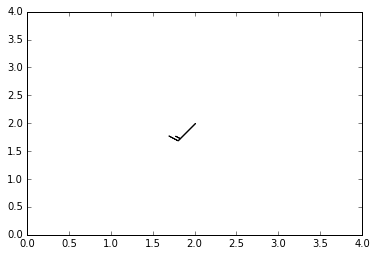

In [16]:
from matplotlib import pyplot
import numpy as np

# Make a 5x5 grid of missing u,v values
u = np.ma.masked_equal(np.zeros((5,5)), 0)
v = np.ma.masked_equal(np.zeros((5,5)), 0)

# Add u,v winds to center of domain
u[2,2] = 10.0
v[2,2] = 10.0

# Draw a single wind barb in the middle using pyplot API
# Note:  the axes objects are "hidden" in these functions
fig = pyplot.figure()
pyplot.barbs(u, v)

# Set the x and y ranges so the barb is in the middle
pyplot.xlim(0, 4)
pyplot.ylim(0, 4)

pyplot.show()




## Mixing the APIs

- Often you will find yourself mixing the object oriented API with the pyplot API.  

- This is required when making subplots, but that is beyond the scope of this tutorial.  

- The next example shows how to make the single wind barb using the axes object directly.

## Your Turn!

### Example 4.2: Single Wind Barb Using the Axes Object

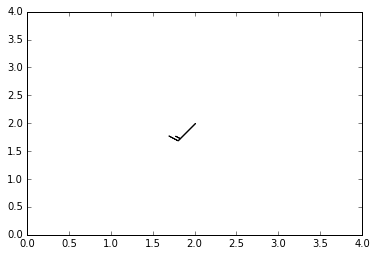

In [17]:
from matplotlib import pyplot
import numpy as np

# Make a 5x5 grid of missing u,v values
u = np.ma.masked_equal(np.zeros((5,5)), 0)
v = np.ma.masked_equal(np.zeros((5,5)), 0)

# Add u,v winds to center of domain
u[2,2] = 10.0
v[2,2] = 10.0

# We'll use pyplot to create the figure and 
# get the axes
fig = pyplot.figure()
ax = pyplot.axes() # <- Remember this line

# Now use the axes directly to create the barbs
ax.barbs(u, v)

# Set the x and y ranges using the axes directly
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

pyplot.show()

## wrf-python Plotting Helper Functions

wrf-python has several functions to help with plotting when using cartopy, basemap, or PyNGL.  

- **get_cartopy, get_basemap, get_pyngl**: Returns the mapping object used by the plotting system
- **latlon_coords**: Returns the latitude and longitude coordinate variables
- **get_bounds**: Returns the geographic boundaries for the variable

## Plotting with cartopy

Cartopy uses the same API as matplotlib by returning a matplotlib.axes.Axes subclass (cartopy.mpl.geoaxes.GeoAxes) when a *projection* keyword argument is passed to the matplotlib.pyplot.axes function.  

### Getting the GeoAxes object

``` python
import matplotlib.pyplot
import cartopy.crs

# Set up a standard map for latlon data.
latlon = cartopy.crs.PlateCarree()

geo_axes = pyplot.axes(projection=latlon)

```

### Getting the cartopy projection object and lat,lon coordinates using wrf-python

- When xarray is installed and enabled, wrf-python carries the projection information around in the metadata of a variable.  

- You can use the *get_cartopy* function to extract the cartopy projection object from a variable. 

- You can use the *latlon_coords* function to get the latitude and longitude points.


``` python
from netCDF4 import Dataset
from wrf import (getvar, get_cartopy, 
                 latlon_coords)

file_path = "./wrfout_d01_2005-08-28_00:00:00"

wrf_file = Dataset(file_path)

terrain = getvar(wrf_file, "ter", timeidx=0)

cart_proj = get_cartopy(terrain)

lats, lons = latlon_coords(terrain)
```

## Your Turn!

### Example 4.3: Making a Plot of Terrain

Let's make a plot of terrain.  It's the easiest way to check if your map is correct.

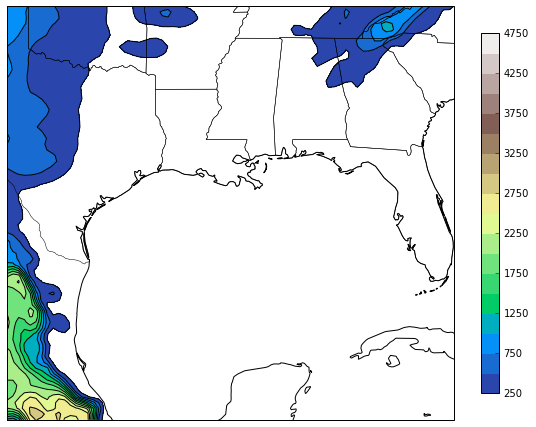

In [18]:
import numpy
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset
from wrf import getvar, to_np, get_cartopy, latlon_coords

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

# Get the terrain height
terrain = getvar(wrf_file, "ter", timeidx=0)

# Get the cartopy object and the lat,lon coords
cart_proj = get_cartopy(terrain)
lats, lons = latlon_coords(terrain)

# Create a figure and get the GetAxes object
fig = pyplot.figure(figsize=(10, 7.5))
geo_axes = pyplot.axes(projection=cart_proj)

# Download and add the states and coastlines
# See the cartopy documentation for more on this.
states = NaturalEarthFeature(category='cultural', 
                             scale='50m', 
                             facecolor='none',
                             name='admin_1_states_provinces_shp')
geo_axes.add_feature(states, linewidth=.5)
geo_axes.coastlines('50m', linewidth=0.8)

# Set the contour levels
levels = numpy.arange(250., 5000., 250.)

# Make the contour lines and fill them.
pyplot.contour(to_np(lons), to_np(lats), 
               to_np(terrain), levels=levels, 
               colors="black",
               transform=crs.PlateCarree())
pyplot.contourf(to_np(lons), to_np(lats), 
                to_np(terrain), levels=levels,
                transform=crs.PlateCarree(),
                cmap=get_cmap("terrain"))
             
# Add a color bar. The shrink often needs to be set 
# by trial and error.
pyplot.colorbar(ax=geo_axes, shrink=.86)

pyplot.show()

## Cropping

Sometimes WRF domains are much larger than what you care about.

Plots can be cropped in two ways using wrf-python:

1. Crop the data before plotting.
  - Less data to process = faster!
  - There's a slight risk of issues at borders, 
    but matplotlib seems pretty smart about this.
2. Crop the domain with matplotlib using x,y axis limits.
  - Runs slower since all of the domain is contoured.
  - Should always be correct.

### Method 1: Cropping then Plotting

If you are cropping the data, then cartopy should just work without worrying about setting the axis limits, as long as xarray is installed and enabled.

Let's start by taking a quick look at the full plot of sea level pressure.


## Your Turn!

### Example 4.4: Plot of Sea Level Pressure

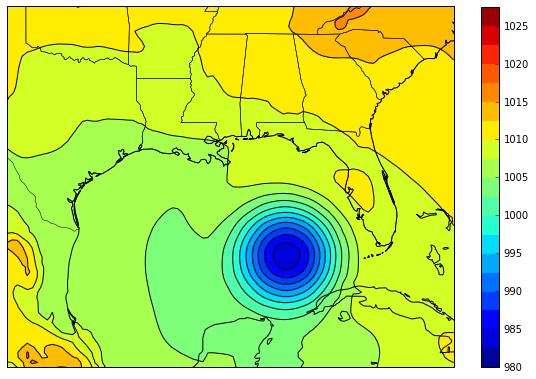

In [19]:
import numpy
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset
from wrf import getvar, to_np, get_cartopy, latlon_coords

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

# Get the terrain height
slp = getvar(wrf_file, "slp", timeidx=0)

# Get the cartopy object and the lat,lon coords
cart_proj = get_cartopy(slp)
lats, lons = latlon_coords(slp)

# Create a figure and get the GetAxes object
fig = pyplot.figure(figsize=(10, 7.5))
geo_axes = pyplot.axes(projection=cart_proj)

# Download and add the states and coastlines
# See the cartopy documentation for more on this.
states = NaturalEarthFeature(category='cultural', 
                             scale='50m', 
                             facecolor='none',
                             name='admin_1_states_provinces_shp')
geo_axes.add_feature(states, linewidth=.5)
geo_axes.coastlines('50m', linewidth=0.8)

# Set the contour levels so that all plots match
levels = numpy.arange(980.,1030.,2.5)

# Make the contour lines and fill them.
pyplot.contour(to_np(lons), to_np(lats), 
               to_np(slp), levels=levels, colors="black",
               transform=crs.PlateCarree())
pyplot.contourf(to_np(lons), to_np(lats), 
                to_np(slp), levels=levels, 
                transform=crs.PlateCarree(),
                cmap=get_cmap("jet"))
             
# Add a color bar. The shrink often needs to be set 
# by trial and error.
pyplot.colorbar(ax=geo_axes, shrink=.86)

pyplot.show()

## Your Turn!

### Example 4.5: Cropping by Slicing the Data

Let's crop the data to the lower right quadrant.

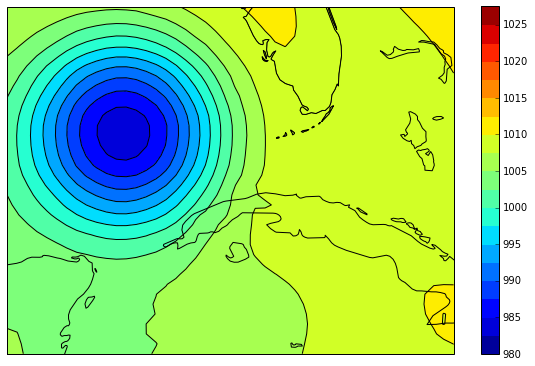

In [20]:
import numpy
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset
from wrf import getvar, to_np, get_cartopy, latlon_coords

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

# Get the terrain height
slp = getvar(wrf_file, "slp", timeidx=0)

# Determine the center of the domain in grid coordinates
slp_shape = slp.shape
center_y = int(slp_shape[-2]/2.) - 1
center_x = int(slp_shape[-1]/2.) - 1

# Slice from bottom to middle for y
# Slice from middle to right for x
slp_quad = slp[..., 0:center_y+1, center_x:]

# Get the cartopy object and the lat,lon coords
cart_proj = get_cartopy(slp_quad)
lats, lons = latlon_coords(slp_quad)

# Create a figure and get the GetAxes object
fig = pyplot.figure(figsize=(10, 7.5))
geo_axes = pyplot.axes(projection=cart_proj)

# Download and add the states and coastlines
# See the cartopy documentation for more on this.
states = NaturalEarthFeature(category='cultural', 
                             scale='50m', 
                             facecolor='none',
                             name='admin_1_states_provinces_shp')
geo_axes.add_feature(states, linewidth=.5)
geo_axes.coastlines('50m', linewidth=0.8)

# Set the contour levels so that all plots match
levels = numpy.arange(980.,1030.,2.5)

# Make the contour lines and fill them.
pyplot.contour(to_np(lons), to_np(lats), 
               to_np(slp_quad), levels=levels, colors="black",
               transform=crs.PlateCarree())
pyplot.contourf(to_np(lons), to_np(lats), 
                to_np(slp_quad), levels=levels, 
                transform=crs.PlateCarree(),
                cmap=get_cmap("jet"))
             
# Add a color bar. The shrink often needs to be set 
# by trial and error.
pyplot.colorbar(ax=geo_axes, shrink=.83)

pyplot.show()

### Method 2: Cropping by Setting x and y Extents

This time, let's crop the domain by using the x and y extents in matplotlib.

Also, we're going to crop the domain using lat,lon geographic boundaries.

### Introducing the GeoBounds class

To create geographic boundaries, you supply a GeoBounds object constructed with set of bottom_left and top_right CoordPair objects.

The CoordPair objects need to use the *lat* and *lon* arguments.

``` python

from wrf import CoordPair, GeoBounds

bottom_left = CoordPair(lat=29.5, lon=-110)
top_right = CoordPair(lat=30.0, lon=-109.3)

geo_bounds = GeoBounds(bottom_left, top_right)

```

### Setting the Cartopy Extents

After setting up the GeoBounds objects, you can use *cartopy_xlim* and *cartopy_ylim* functions to set the extents.  

Note: Cartopy also has an API for doing this, but it doesn't work correctly for some projections like the RotatedPole.  


``` python
from wrf import (CoordPair, GeoBounds, 
                 getvar, cartopy_xlim, 
                 cartopy_ylim)

bottom_left = CoordPair(lat=29.5, lon=-110)
top_right = CoordPair(lat=30.0, lon=-109.3)

geo_bounds = GeoBounds(bottom_left, top_right)
.
. (Set up variable, figure, geo_axes, etc)
.

xlim = cartopy_xlim(variable, 
                    geobounds=geo_bounds))
                    
geo_axes.set_xlim(xlim)
         
ylim = cartopy_ylim(variable,
                    geobounds=geo_bounds))
                    
geo_axes.set_ylim(ylim)


```

## Your Turn!

### Example 4.6: Cropping by Setting the X,Y Extents

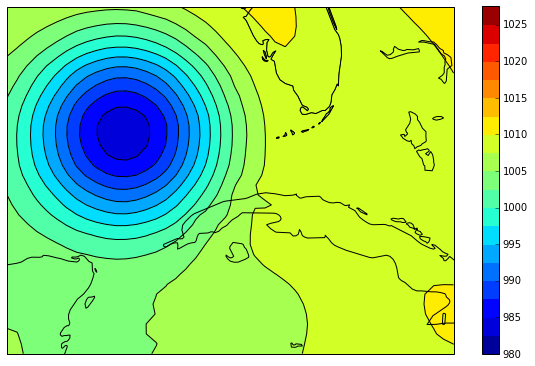

In [21]:
import numpy
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset
from wrf import getvar, to_np, get_cartopy, latlon_coords
from wrf import xy_to_ll, cartopy_xlim, cartopy_ylim
from wrf import CoordPair, GeoBounds

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

# Get the terrain height
slp = getvar(wrf_file, "slp", timeidx=0)

# Get the cartopy object and the lat,lon coords
cart_proj = get_cartopy(slp)
lats, lons = latlon_coords(slp)

# Create a figure and get the GetAxes object
fig = pyplot.figure(figsize=(10, 7.5))
geo_axes = pyplot.axes(projection=cart_proj)

# Download and add the states and coastlines
# See the cartopy documentation for more on this.
states = NaturalEarthFeature(category='cultural', 
                             scale='50m', 
                             facecolor='none',
                             name='admin_1_states_provinces_shp')
geo_axes.add_feature(states, linewidth=.5)
geo_axes.coastlines('50m', linewidth=0.8)

# Set the contour levels so that all plots match
levels = numpy.arange(980.,1030.,2.5)

# Make the contour lines and fill them.
pyplot.contour(to_np(lons), to_np(lats), 
               to_np(slp), levels=levels, colors="black",
               transform=crs.PlateCarree())
pyplot.contourf(to_np(lons), to_np(lats), 
                to_np(slp), levels=levels, 
                transform=crs.PlateCarree(),
                cmap=get_cmap("jet"))
             
# Add a color bar. The shrink often needs to be set 
# by trial and error.
pyplot.colorbar(ax=geo_axes, shrink=.83)

# Set up the x, y extents

# Determine the center of the domain in grid coordinates
slp_shape = slp.shape
start_y = 0
center_y = int(slp_shape[-2]/2.) - 1
center_x = int(slp_shape[-1]/2.) - 1
end_x = int(slp_shape[-1]) - 1

# Get the lats and lons for the start, center, and end points
# (Normally you would just set these yourself)
center_latlon = xy_to_ll(wrf_file, 
                         [center_x, end_x], 
                         [start_y, center_y])

start_lat = center_latlon[0,0]
end_lat = center_latlon[0,1]
start_lon = center_latlon[1,0]
end_lon = center_latlon[1,1]

# Set the extents
geo_bounds = GeoBounds(CoordPair(lat=start_lat, lon=start_lon),
                       CoordPair(lat=end_lat, lon=end_lon))
geo_axes.set_xlim(cartopy_xlim(slp, geobounds=geo_bounds))
geo_axes.set_ylim(cartopy_ylim(slp, geobounds=geo_bounds))

pyplot.show()

# 5.0 Advanced Examples

These examples are a significant jump in difficulty from the previous ones. 

We won't have time to cover them in detail, so hang on to them for future reference when you begin making real world plots.

## 5.1: Overlaying Multiple Diagnostics

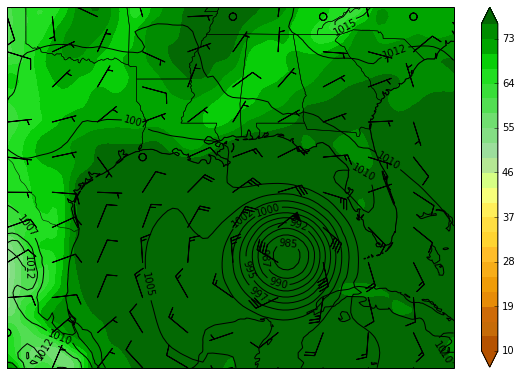

In [22]:
import numpy
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset
from wrf import getvar, to_np, get_cartopy, latlon_coords, cartopy_xlim, cartopy_ylim

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

# Get the slp, td2, u, and v variables
slp = getvar(wrf_file, "slp", timeidx=0)
td2 = getvar(wrf_file, "td2", timeidx=0, units="degF")
u_sfc = getvar(wrf_file, "ua", timeidx=0, units="kt")[0,:]
v_sfc = getvar(wrf_file, "va", timeidx=0, units="kt")[0,:]

# Get the cartopy object and the lat,lon coords
cart_proj = get_cartopy(slp)
lats, lons = latlon_coords(slp)

# Create a figure and get the GetAxes object
fig = pyplot.figure(figsize=(10, 7.5))
geo_axes = pyplot.axes(projection=cart_proj)

# Download and add the states and coastlines
# See the cartopy documentation for more on this.
states = NaturalEarthFeature(category='cultural', 
                             scale='50m', 
                             facecolor='none',
                             name='admin_1_states_provinces_shp')
geo_axes.add_feature(states, linewidth=.5)
geo_axes.coastlines('50m', linewidth=0.8)

# Manually setting the contour levels
slp_levels = numpy.arange(980.,1030.,2.5)
td2_levels = numpy.arange(10., 79., 3.)


# Manually setting the td2 RGB colors (normalized to 1)
td2_rgb = numpy.array([[181,82,0], [181,82,0],
                  [198,107,8], [206,107,8],
                  [231,140,8], [239,156,8],
                  [247,173,24], [255,189,41],
                  [255,212,49], [255,222,66],
                  [255,239,90], [247,255,123],
                  [214,255,132], [181,231,148],
                  [156,222,156], [132,222,132],
                  [112,222,112], [82,222,82],
                  [57,222,57], [33,222,33],
                  [8,206,8], [0,165,0],
                  [0,140,0], [3,105,3]]) / 255.0
    
td2_cmap, td2_norm = from_levels_and_colors(td2_levels, td2_rgb, extend="both")

# Make the contour lines and fill them.
slp_contours = pyplot.contour(to_np(lons), 
                              to_np(lats), 
                              to_np(slp), 
                              levels=slp_levels, 
                              colors="black",
                              transform=crs.PlateCarree())

pyplot.contourf(to_np(lons), to_np(lats), 
                to_np(td2), levels=td2_levels, 
                cmap=td2_cmap, norm=td2_norm,
                extend="both",
                transform=crs.PlateCarree())

# Plot the wind barbs, but only plot ~10 barbs in each direction.
thin = [int(x/10.) for x in lons.shape]
pyplot.barbs(to_np(lons[::thin[0], ::thin[1]]), 
             to_np(lats[::thin[0], ::thin[1]]), 
             to_np(u_sfc[::thin[0], ::thin[1]]), 
             to_np(v_sfc[::thin[0], ::thin[1]]),
             transform=crs.PlateCarree())

# Add contour labels for pressure
pyplot.clabel(slp_contours, fmt="%i")

# Add a color bar. The shrink often needs to be set 
# by trial and error.
pyplot.colorbar(ax=geo_axes, shrink=.86, extend="both")

# Set the map bounds
pyplot.xlim(cartopy_xlim(slp))
pyplot.ylim(cartopy_ylim(slp))

pyplot.show()

## Example 5.2: Upper Level Heights and Winds with *interplevel*

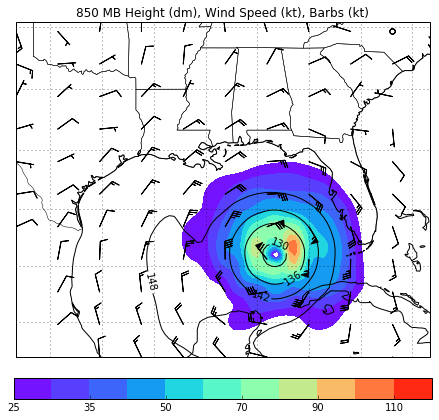

In [23]:
import numpy
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, interplevel,
                 cartopy_xlim, cartopy_ylim)

file_path = single_wrf_file()
wrf_file = Dataset(file_path)

# Extract the pressure, geopotential height, and wind variables
p = getvar(wrf_file, "pressure")
z = getvar(wrf_file, "z", units="dm")
ua = getvar(wrf_file, "ua", units="kt")
va = getvar(wrf_file, "va", units="kt")
wspd = getvar(wrf_file, "wspd_wdir", units="kt")[0,:]

# Interpolate geopotential height, u, and v winds to 850 hPa
ht_850 = interplevel(z, p, 850)
u_850 = interplevel(ua, p, 850)
v_850 = interplevel(va, p, 850)
wspd_850 = interplevel(wspd, p, 850)

# Get the lat/lon coordinates
lats, lons = latlon_coords(ht_850)

# Get the map projection information
cart_proj = get_cartopy(ht_850)

# Create the figure
fig = pyplot.figure(figsize=(10,7.5))
ax = pyplot.axes(projection=cart_proj)

# Download and add the states and coastlines
states = NaturalEarthFeature(category='cultural', 
                             scale='50m', 
                             facecolor='none',
                             name='admin_1_states_provinces_shp')
ax.add_feature(states, linewidth=0.5)
ax.coastlines('50m', linewidth=0.8)

# Add the 850 hPa geopotential height contours
levels = numpy.arange(130., 170., 6.)
contours = pyplot.contour(to_np(lons), 
                       to_np(lats), 
                       to_np(ht_850), 
                       levels=levels, 
                       colors="black",
                       transform=crs.PlateCarree())

pyplot.clabel(contours, inline=1, fontsize=10, fmt="%i")

# Add the wind speed contours
levels = [25, 30, 35, 40, 50, 60, 70, 80, 90, 100, 110, 120]
wspd_contours = pyplot.contourf(to_np(lons), 
                             to_np(lats), 
                             to_np(wspd_850), 
                             levels=levels,
                             cmap=get_cmap("rainbow"),
                             transform=crs.PlateCarree())

pyplot.colorbar(wspd_contours, ax=ax, orientation="horizontal", 
             pad=.05, shrink=.75)

# Add the 850 hPa wind barbs, only plotting 10 barbs in each direction
# Also, skipping the border barbs.
thin = [int(x/10.) for x in lons.shape]
pyplot.barbs(to_np(lons[::thin[0], ::thin[1]]), 
          to_np(lats[::thin[0], ::thin[1]]), 
          to_np(u_850[::thin[0], ::thin[1]]),
          to_np(v_850[::thin[0], ::thin[1]]), 
          length=6,
          transform=crs.PlateCarree())

# Set the map bounds
ax.set_xlim(cartopy_xlim(ht_850))
ax.set_ylim(cartopy_ylim(ht_850))

ax.gridlines()

pyplot.title("850 MB Height (dm), Wind Speed (kt), Barbs (kt)")

pyplot.show()

## Example 5.3: Cross Section

Begin by defining a cross section line in latitude, longitude coordinates.

In [24]:
from wrf import CoordPair

cross_start = CoordPair(lat=24.8, lon=-88.7)
cross_end = CoordPair(lat=24.8, lon=-83.7)

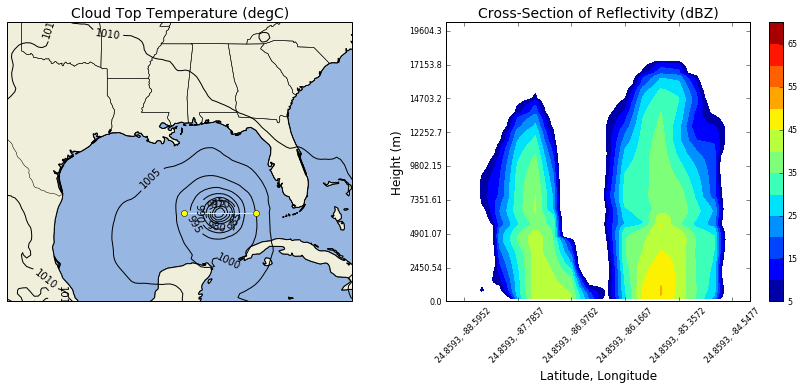

In [25]:
import numpy
from matplotlib import pyplot
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim)

file_path = multiple_wrf_files()
wrf_file = [Dataset(x) for x in file_path]

# Get the WRF variables
slp = getvar(wrf_file, "slp", timeidx=1)
z = getvar(wrf_file, "z", timeidx=1)
dbz = getvar(wrf_file, "dbz", timeidx=1)
Z = 10**(dbz/10.) # Use linear Z for interpolation

# Compute the vertical cross-section interpolation.  Also, include the lat/lon
# points along the cross-section in the metadata by setting latlon to True.
z_cross = vertcross(Z, z, wrfin=wrf_file, 
                    start_point=cross_start, 
                    end_point=cross_end,
                    latlon=True, meta=True)

# Convert back to dBz after interpolation
dbz_cross = 10.0 * numpy.log10(z_cross)

# Get the lat/lon points
lats, lons = latlon_coords(slp)

# Get the cartopy projection object
cart_proj = get_cartopy(slp)

# Create a figure that will have 2 subplots (1 row, 2 columns)
fig = pyplot.figure(figsize=(15,5))
ax_slp = fig.add_subplot(1,2,1,projection=cart_proj)
ax_dbz = fig.add_subplot(1,2,2)

# Download and create the states, land, and oceans using cartopy features
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                                      name='admin_1_states_provinces_shp')
land = NaturalEarthFeature(category='physical', name='land', scale='50m',
                                    facecolor=COLORS['land'])
ocean = NaturalEarthFeature(category='physical', name='ocean', scale='50m',
                                     facecolor=COLORS['water'])

# Make the pressure contours
slp_levels = numpy.arange(950.,1030.,5)
slp_contours = ax_slp.contour(to_np(lons), 
                    to_np(lats), 
                    to_np(slp), 
                    levels=slp_levels, 
                    colors="black", 
                    zorder=3, 
                    transform=crs.PlateCarree())
# Add contour labels for pressure
ax_slp.clabel(slp_contours, fmt="%i")

# Draw the cross section line
ax_slp.plot([cross_start.lon, cross_end.lon], 
            [cross_start.lat, cross_end.lat],
            color="yellow", 
            marker="o",  
            zorder=3,
            transform=crs.PlateCarree())

# Draw the oceans, land, and states
ax_slp.add_feature(ocean)
ax_slp.add_feature(land)
ax_slp.add_feature(states, linewidth=.5, edgecolor="black")

# Make the contour plot for dbz
dbz_levels = numpy.arange(5.,75.,5.)
dbz_contours = ax_dbz.contourf(to_np(dbz_cross), levels=dbz_levels, cmap=get_cmap("jet"))
cb_dbz = fig.colorbar(dbz_contours, ax=ax_dbz)
cb_dbz.ax.tick_params(labelsize=8)

# Set the x-ticks to use latitude and longitude labels
coord_pairs = to_np(dbz_cross.coords["xy_loc"])
x_ticks = numpy.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
# Only keeping ~5 xticks
thin = [int(x/5.) for x in x_ticks.shape]
ax_dbz.set_xticks(x_ticks[1::thin[0]])
ax_dbz.set_xticklabels(x_labels[::thin[0]], rotation=45, fontsize=8)

# Set the y-ticks to be height
vert_vals = to_np(dbz_cross.coords["vertical"])
v_ticks = numpy.arange(vert_vals.shape[0])
# Only keeping ~8 vertical ticks
thin = [int(x/8.) for x in v_ticks.shape]
ax_dbz.set_yticks(v_ticks[::thin[0]])
ax_dbz.set_yticklabels(vert_vals[::thin[0]], fontsize=8)

# Set the x-axis and  y-axis labels
ax_dbz.set_xlabel("Latitude, Longitude", fontsize=12)
ax_dbz.set_ylabel("Height (m)", fontsize=12)

# Add a title
ax_slp.set_title("Cloud Top Temperature (degC)", {"fontsize" : 14})
ax_dbz.set_title("Cross-Section of Reflectivity (dBZ)", {"fontsize" : 14})

pyplot.show()

## Example 5.4: Animations

In [26]:
import numpy
from matplotlib import pyplot, rc
from matplotlib.cm import get_cmap
from matplotlib.colors import from_levels_and_colors
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from cartopy import crs
from cartopy.feature import NaturalEarthFeature, COLORS
from netCDF4 import Dataset
from wrf import (getvar, to_np, get_cartopy, latlon_coords, vertcross,
                 cartopy_xlim, cartopy_ylim, ALL_TIMES)

file_path = multiple_wrf_files()
wrf_file = [Dataset(x) for x in file_path]

# Get SLP for all times
slp_all = getvar(wrf_file, "slp", timeidx=ALL_TIMES)

# Get the cartopy projection object
cart_proj = get_cartopy(slp_all)

fig = pyplot.figure(figsize=(10,7.5))
ax_slp = pyplot.axes(projection=cart_proj)

# Download and create the states, land, and oceans using cartopy features
states = NaturalEarthFeature(category='cultural', scale='50m', facecolor='none',
                                      name='admin_1_states_provinces_shp')
land = NaturalEarthFeature(category='physical', name='land', scale='50m',
                                    facecolor=COLORS['land'])
ocean = NaturalEarthFeature(category='physical', name='ocean', scale='50m',
                                     facecolor=COLORS['water'])

slp_levels = numpy.arange(950.,1030.,5.)

num_frames = slp_all.shape[0]

def animate(i):
    ax_slp.clear()
    slp = slp_all[i,:]
    
    # Get the lat/lon coordinates
    lats, lons = latlon_coords(slp)
    
    ax_slp.add_feature(ocean)
    ax_slp.add_feature(land)
    ax_slp.add_feature(states, linewidth=.5, edgecolor="black")
    
    slp_contours = ax_slp.contour(to_np(lons), 
                              to_np(lats), 
                              to_np(slp), 
                              levels=slp_levels,
                              colors="black", 
                              zorder=5,
                              transform=crs.PlateCarree()) 
    
    # Add contour labels for pressure
    ax_slp.clabel(slp_contours, fmt="%i")
    
    # Set the map bounds
    ax_slp.set_xlim(cartopy_xlim(slp))
    ax_slp.set_ylim(cartopy_ylim(slp))
        
    return ax_slp

ani = FuncAnimation(fig, animate, num_frames, interval=500, repeat_delay=1000, blit=False)

HTML(ani.to_html5_video())

